# System versions

- cuda 12
    1. Install appropriate cupy version matching with cuda
        - pip install cupy-cuda12x
    3. On CUDA 12.2 or later, CUDA Runtime header files are required to compile kernels in CuPy
        - pip install "nvidia-cuda-runtime-cu12==12.6.*"

In [1]:
is_use_source = True

if is_use_source:
    import os
    os.environ["boostrsa_isRunSource"] = "True"
    os.environ["boostrsa_source_home"] = "/home/seojin/boostrsa/src/boostrsa"

# Common Library

In [85]:
import os
import sys
import numpy as np 
import cupy as cp
from scipy.stats import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import nibabel as nb
from collections import Counter
from copy import copy
from nilearn.plotting import plot_design_matrix
from sklearn.linear_model import LinearRegression
from itertools import product, combinations

# rsatoolbox
from rsatoolbox import vis
from rsatoolbox.rdm import calc_rdm, concat, RDMs
from rsatoolbox.data.dataset import Dataset
from rsatoolbox.data.noise import prec_from_residuals
from rsatoolbox.util.searchlight import get_volume_searchlight

# boostrsa
is_use_source = True
    
if os.getenv("boostrsa_isRunSource"):
    sys.path.append("../src/boostrsa")
    from boostrsa_types import ShrinkageMethod
    from searchlight import calc_sl_precisions, calc_sl_rdm_crossnobises, calc_sl_precision, calc_sl_rdm_crossnobis, calc_sqrt_precisions
    from searchlight import calc_sl_rdm_crossnobises_SS
else:
    from boostrsa.boostrsa_types import ShrinkageMethod
    from boostrsa.searchlight import calc_sl_precisions, calc_sl_rdm_crossnobises, calc_sl_precision, calc_sl_rdm_crossnobis, calc_sqrt_precisions
    from boostrsa.searchlight import calc_sl_rdm_crossnobises_SS

In [3]:
from numba import cuda
cuda.select_device(0)
device = cuda.get_current_device()
print("GPU: ", device)

GPU:  <CUDA device 0 'b'NVIDIA GeForce RTX 3090''>


# Configuration

In [4]:
# Set your cuda path 
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.6" # for linux

# Parameters

In [5]:
# Save directory
save_dir_path = "/mnt/ext1/seojin/temp"
is_use_fullMask = False
data_type = np.float64

## Simulation parameters

In [6]:
if is_use_fullMask:
    mask = nb.load(os.path.join("..", "data", "full_mask.nii.gz"))
    brain_shape = mask.shape
    nx, ny, nz = brain_shape
    affine = mask.affine
    mask = mask.get_fdata()
else:
    # Brain
    brain_shape = (30, 30, 30)
    nx, ny, nz = brain_shape
    
    # Mask of brain
    mask = np.zeros(brain_shape).astype(np.uint8)
    mask[20:30, 20:30, 20:30] = 1
    
    # Create an affine transformation matrix (2mm isotropic voxels, no rotation)
    affine = np.diag([2, 2, 2, 1])

# Simulation experiment parameters
n_timepoints = 300  # total time points
stimuli_types = {
    "stim1" : 1,
    "stim2" : 2,
    "stim3" : 3,
    "stim4" : 4,
    "stim1_ISI" : 5,
    "stim2_ISI" : 6,
    "stim3_ISI" : 7,
    "stim4_ISI" : 8,
}
stimuli_withISI = np.array(list(stimuli_types.keys()))
stimuli = stimuli_withISI[["ISI" not in e for e in stimuli_withISI]]
ISIs = stimuli_withISI[["ISI" in e for e in stimuli_withISI]]

response_duration = 10  # duration of response in timepoints
n_run = 3

# HRF Parameters
hrf_times = np.arange(0, 30, 1)  # 30 time points for the HRF
peak = 6
undershoot = 12
ratio = 0.35
hrf = gamma.pdf(hrf_times, peak) - ratio * gamma.pdf(hrf_times, undershoot)

# Response parameter
response_amplitudes = {
    "stim1" : (np.random.random(brain_shape) * 8),
    "stim2" : (np.random.random(brain_shape) * 4),
    "stim3" : (np.random.random(brain_shape) * 2),
    "stim4" : (np.random.random(brain_shape)),
    "stim1_ISI" : (np.zeros(brain_shape)),
    "stim2_ISI" : (np.zeros(brain_shape)),
    "stim3_ISI" : (np.zeros(brain_shape)),
    "stim4_ISI" : (np.zeros(brain_shape)),
}

# Generate datas

## Simulate experiment

In [7]:
stimulus_timings_perRun = []
for run_i in range(n_run):
    stimulus_timings = np.zeros(n_timepoints)
    
    sudo_random_stim = list(stimuli)
    
    current_time = 0
    while current_time < n_timepoints:
        stimulus = np.random.choice(sudo_random_stim)
        onset = current_time
        duration = response_duration
        offset = min(current_time + duration, n_timepoints)

        # Simulate response
        stimulus_timings[onset:offset] += stimuli_types[stimulus]

        # Add inter stimulus interval
        isi = np.random.randint(5, 15)
        current_time += duration + isi
        stimulus_timings[onset + duration:current_time] += stimuli_types[stimulus + "_ISI"]
        
        sudo_random_stim.remove(stimulus)
        if len(sudo_random_stim) == 0:
            sudo_random_stim = list(stimuli)
            
    run_stim_df = pd.get_dummies(stimulus_timings.astype(np.uint8))
    run_stim_df.columns = stimuli_withISI
    run_stim_df = run_stim_df.astype(np.uint8)
    stimulus_timings_perRun.append(run_stim_df)

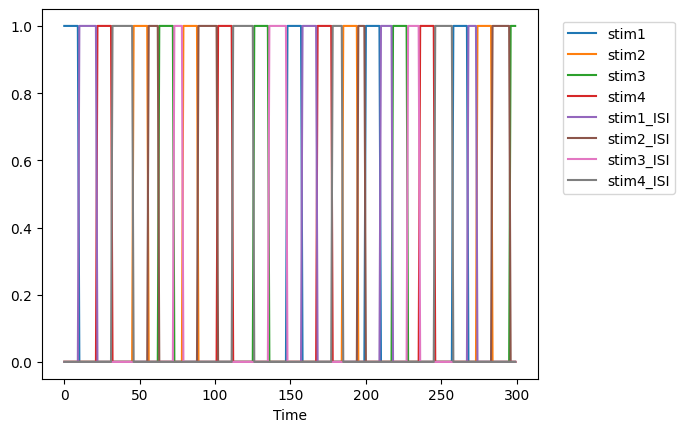

In [8]:
run_i = 0
for stim in stimuli_withISI:
    plt.plot(stimulus_timings_perRun[run_i][stim], label = stim)

plt.xlabel("Time")
plt.legend(loc = (1.05, 0.5))

## Simulate brain response

In [9]:
# stimulate reference brain response in correspond to stimulus
reference_brain_response_perRun = copy(stimulus_timings_perRun)
for run_i in range(n_run):
    for stim in stimuli_types:
        reference_brain_response_perRun[run_i][stim] = np.convolve(reference_brain_response_perRun[run_i][stim], hrf, mode = "full")[:n_timepoints]

In [10]:
# population beta 
population_betas = np.array([response_amplitudes[stim] for stim in stimuli_withISI])
population_betas = population_betas.reshape(len(stimuli_withISI), -1)

In [11]:
# Mask
mask_3d_indexes = np.array(np.where(mask == 1))
mask_1d_indexes = np.ravel_multi_index(mask_3d_indexes, (nx, ny, nz))

In [12]:
noise_level = 2

fmri_data = np.zeros((n_run, n_timepoints, nx, ny, nz))
for run_i in range(n_run):
    reference_activation = reference_brain_response_perRun[run_i].to_numpy()
    
    # population response
    response = (reference_activation @ population_betas)
    
    # noise
    noise = np.random.normal(0, noise_level * (run_i+1), n_timepoints) # Add Gaussian noise
    noise = noise.reshape(n_timepoints, 1)
    
    response_with_noise = response + noise
    
    # brain response
    fmri_data[run_i, :, :, :] = (response_with_noise).reshape(n_timepoints, nx, ny, nz)
mask_fmri = np.expand_dims(np.expand_dims(mask, 0), 0)
fmri_data = fmri_data[:, :] * mask

# Get beta values & residuals

In [13]:
design_mats = copy(reference_brain_response_perRun)

<Axes: label='conditions', ylabel='scan number'>

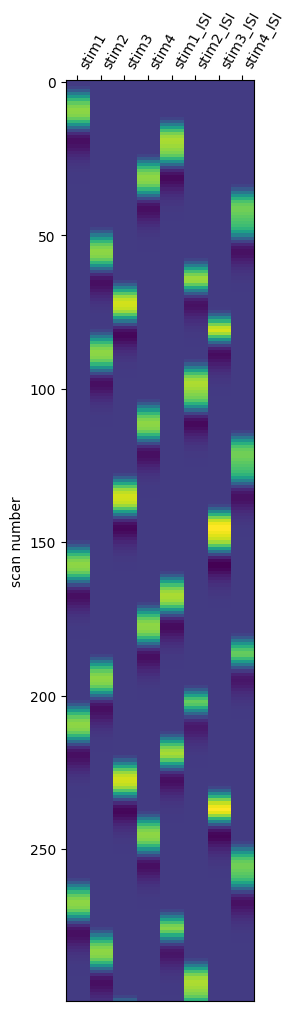

In [14]:
plot_design_matrix(design_mats[0]) # *bias is automatically included in linear regression model

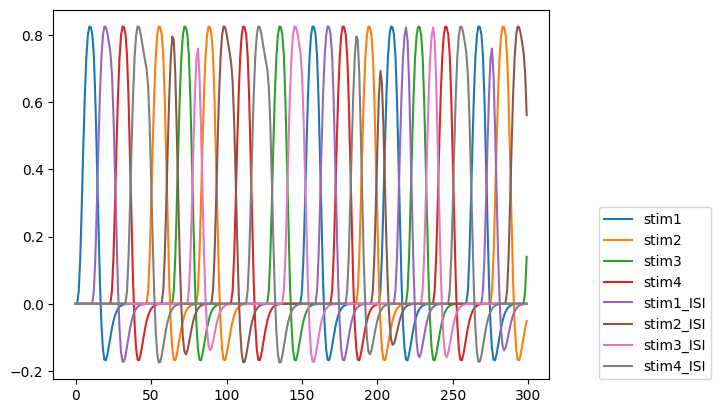

In [15]:
run_i = 0 

plt.plot(design_mats[run_i])
plt.legend(design_mats[run_i].columns, loc = (1.1, 0))

In [16]:
# run, time, nx, ny, nz -> run, nx, ny, nz, time
fmri_data = fmri_data.transpose(0, 2, 3, 4, 1)

## For stim

In [17]:
stim_design_mats = [design_mat.loc[:, ["ISI" not in e for e in design_mat.columns]] for design_mat in design_mats]

In [18]:
model = LinearRegression()

stim_coefficients = np.zeros((n_run, nx, ny, nz, len(stimuli)))
stim_intercepts = np.zeros((n_run, nx, ny, nz))
stim_residuals = np.zeros(fmri_data.shape)

In [19]:
for run_i in tqdm(range(n_run)):
    design_mat = stim_design_mats[run_i]
    
    for j in range(len(mask_3d_indexes[1])):
        # Linear regression
        x,y,z = mask_3d_indexes[:, j]
        target = fmri_data[run_i, x,y,z, :]
        model.fit(design_mat, target)
        
        # Intercept
        stim_intercepts[run_i, x,y,z] = model.intercept_
        
        # Coef
        stim_coefficients[run_i, x,y,z, :] = model.coef_
        
        # Residual
        residual = target - model.predict(design_mat)
        stim_residuals[run_i, x,y,z, :] = residual

100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


In [20]:
# Beta
stim_betas = stim_coefficients[:, :, :, :, ["stim" in e for e in np.array(stimuli)]]
stim_betas = stim_betas[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
stim_betas = np.concatenate([beta_perRun for beta_perRun in stim_betas], axis = 1)
stim_betas = stim_betas.transpose(1, 0)

# Residual
stim_residuals = stim_residuals[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
stim_residuals = stim_residuals.transpose(0, 2, 1)

# Condition
stimuli = np.array(stimuli)
target_stimuli = stimuli[["stim" in e for e in stimuli]]
stim_conditions = np.concatenate([target_stimuli for _ in range(n_run)])

# Session
stim_sessions = []
for run_index in range(n_run):
    run_number = run_index + 1
    stim_sessions += [np.repeat(run_number, len(target_stimuli))]
stim_sessions = np.concatenate(stim_sessions)

## For ISI

In [21]:
stimISI_design_mats = [design_mat.loc[:, ["ISI" in e for e in design_mat.columns]] for design_mat in design_mats]

In [22]:
model = LinearRegression()

stimISI_coefficients = np.zeros((n_run, nx, ny, nz, len(ISIs)))
stimISI_intercepts = np.zeros((n_run, nx, ny, nz))
stimISI_residuals = np.zeros(fmri_data.shape)

In [23]:
for run_i in tqdm(range(n_run)):
    design_mat = stimISI_design_mats[run_i]
    
    for j in range(len(mask_3d_indexes[1])):
        # Linear regression
        x,y,z = mask_3d_indexes[:, j]
        target = fmri_data[run_i, x,y,z, :]
        model.fit(design_mat, target)
        
        # Intercept
        stimISI_intercepts[run_i, x,y,z] = model.intercept_
        
        # Coef
        stimISI_coefficients[run_i, x,y,z, :] = model.coef_
        
        # Residual
        residual = target - model.predict(design_mat)
        stimISI_residuals[run_i, x,y,z, :] = residual

100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


In [24]:
# Beta
stimISI_betas = stimISI_coefficients[:, :, :, :, ["ISI" in e for e in np.array(ISIs)]]
stimISI_betas = stimISI_betas[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
stimISI_betas = np.concatenate([beta_perRun for beta_perRun in stimISI_betas], axis = 1)
stimISI_betas = stimISI_betas.transpose(1, 0)

# Residual
stimISI_residuals = stimISI_residuals[:, mask_3d_indexes[0, :], mask_3d_indexes[1, :], mask_3d_indexes[2, :], :]
stimISI_residuals = stimISI_residuals.transpose(0, 2, 1)

# Condition
target_stimuli = ISIs[["ISI" in e for e in ISIs]]
stimISI_conditions = np.concatenate([target_stimuli for _ in range(n_run)])

# Session
stimISI_sessions = []
for run_index in range(n_run):
    run_number = run_index + 1
    stimISI_sessions += [np.repeat(run_number, len(target_stimuli))]
stimISI_sessions = np.concatenate(stimISI_sessions)

# Make appropriate format

Following values' shapes must be matched.

- beta
    - shape: (a number of condition, a number of target voxel)
- residual
    - shape: (a number of session, a number of times on a session, a number of target voxel)
- condition
    - shape (a number of condition)
- session
    - shape: (a number of condition)

# Searchlight region

In [25]:
radius = 3
threshold = 1

centers, neighbors = get_volume_searchlight(mask, 
                                            radius=radius, 
                                            threshold=threshold)
uq_n_neighbors = np.unique([len(e) for e in neighbors])

Finding searchlights...: 100%|██████████| 1000/1000 [00:00<00:00, 12516.54it/s]

Found 512 searchlights


# Organize measurements

In [26]:
# Make dictionary for organizing informations
beta_info = {}
for run_i, subSession in list(product(range(n_run), ["move", "rest"])):
    run_number = run_i + 1

    if subSession == "move":
        target_betas = stim_betas
        target_conditions = stim_conditions
        target_residuals = stim_residuals
        target_sessions = stim_sessions
    else:
        target_betas = stimISI_betas
        target_conditions = stimISI_conditions
        target_residuals = stimISI_residuals
        target_sessions = stimISI_sessions
        
    beta_info[f"{run_number}-{subSession}"] = {
        "beta" : target_betas[target_sessions == run_number],
        "condition" : target_conditions[target_sessions == run_number],
        "residual" : target_residuals[run_i],
    }

# Organize information for "move" subSession only
move_betas = []
move_conditions = []
move_residuals = []
move_residual_types = []
for type_ in beta_info:
    if "move" in type_:
        move_betas.append(beta_info[type_]["beta"])
        move_conditions.append(beta_info[type_]["condition"])
        move_residuals.append(beta_info[type_]["residual"])
        move_residual_types.append(type_)
move_betas = np.concatenate(move_betas, axis = 0) # shape - (#trial, #voxel)
move_conditions = np.concatenate(move_conditions, axis = 0) # shape - (#trial)
move_residuals = np.r_[move_residuals] # shape - (#session * 2, #step, #voxel)
move_residual_types = np.array(move_residual_types) # (shape - #session)
move_data_types = [np.repeat(type_, len(beta_info[type_]["beta"])) for type_ in beta_info if "move" in type_]
move_data_types = np.concatenate(move_data_types, axis = 0)
move_sessions = np.array([type_.split("-")[0] for type_ in move_data_types])
move_subSessions = np.array([type_.split("-")[1] for type_ in move_data_types])

# Organize information for "rest" subSession only
rest_betas = []
rest_conditions = []
rest_residuals = []
rest_residual_types = []
for type_ in beta_info:
    if "rest" in type_:
        rest_betas.append(beta_info[type_]["beta"])
        rest_conditions.append(beta_info[type_]["condition"])
        rest_residuals.append(beta_info[type_]["residual"])
        rest_residual_types.append(type_)
rest_betas = np.concatenate(rest_betas, axis = 0) # shape - (#trial, #voxel)
rest_conditions = np.concatenate(rest_conditions, axis = 0) # shape - (#trial)
rest_residuals = np.r_[rest_residuals] # shape - (#session * 2, #step, #voxel)
rest_residual_types = np.array(rest_residual_types) # (shape - #session)
rest_data_types = [np.repeat(type_, len(beta_info[type_]["beta"])) for type_ in beta_info if "rest" in type_]
rest_data_types = np.concatenate(rest_data_types, axis = 0)
rest_sessions = np.array([type_.split("-")[0] for type_ in rest_data_types])
rest_subSessions = np.array([type_.split("-")[1] for type_ in rest_data_types])

# Organize all information for "move" and "rest"
measurements = np.r_[move_betas, rest_betas]
conditions = np.r_[move_conditions, rest_conditions]
residuals = np.r_[move_residuals, rest_residuals]
residual_types = np.r_[move_residual_types, rest_residual_types]
sessions = np.r_[move_sessions, rest_sessions]
subSessions = np.r_[move_subSessions, rest_subSessions]

In [27]:
uq_move_sessions = np.unique(move_sessions)
uq_move_subSessions = np.unique(move_subSessions)

uq_rest_sessions = np.unique(rest_sessions)
uq_rest_subSessions = np.unique(rest_subSessions)

uq_sessions = np.unique(sessions)
uq_subSessions = np.unique(subSessions)

# Params for calculating precision matrix

In [28]:
shrinkage_method = ShrinkageMethod.shrinkage_eye

# Crossnobis distance

- Notation
    - A, B: session index
    - i, j: condition index
    - α, β: data source index within one session
- rsatoolbox api's crossnobis distance calculation method
    - distance of one cv = $(b_{(A, i)} - b_{(A, j)})\frac{Σ_{A}^{-1} + Σ_{B}^{-1}}{2}(b_{(B, i)} - b_{(B, j)}) $
- Walther 2016's crossnobis distance calculation method
    - distance of one cv = $(b_{(A, i)}Σ_{A}^{-\frac{1}{2}} - b_{(A, j)}Σ_{A}^{-\frac{1}{2}})(b_{(B, i)}Σ_{B}^{-\frac{1}{2}} - b_{(B, j)}Σ_{B}^{-\frac{1}{2}}) $
- Considering two data sources within one session
    - $(b_{(A, i)}Σ_{(A,α)}^{-\frac{1}{2}} - b_{(A, j)}Σ_{(A, β)}^{-\frac{1}{2}})(b_{(B, i)}Σ_{(B, α)}^{-\frac{1}{2}} - b_{(B, j)}Σ_{(B, β)}^{-\frac{1}{2}}) $

# Searchlight - CPU verison (rsatoolbox)

In [29]:
subj_number = 1

# Dummy
rdm_crossnobis_cpus = []

n_center = len(centers)
for i in tqdm(range(n_center)):
    center = centers[i]
    neighbor = neighbors[i]
    
    # Mask
    n_channel = measurements.shape[1]
    mask_out = np.zeros(n_channel)
    for neighbor_pos in neighbor:
        for brain_i, brain_pos in enumerate(mask_1d_indexes):
            if brain_pos == neighbor_pos:
                mask_out[brain_i] = 1
    
    # Data
    masked_betas = measurements[:, mask_out == 1]
    masked_residuals = residuals[:, :, mask_out == 1]
    
    # Precision matrix
    noise_precision_mats = np.array(prec_from_residuals(masked_residuals, method = shrinkage_method))
    
    # Crossnobis
    nVox = masked_betas.shape[-1]
    des = {'subj': subj_number, "voxel_index" : int(center) }
    obs_des = {'conds': conditions, 'sessions': sessions}
    chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}

    dataset = Dataset(measurements = masked_betas,
                      descriptors = des,
                      obs_descriptors = obs_des,
                      channel_descriptors = chn_des)
    rdm_crossnobis = calc_rdm(dataset, 
                              descriptor = "conds", 
                              method = "crossnobis",
                              noise = noise_precision_mats,
                              cv_descriptor = "sessions")
    del rdm_crossnobis.descriptors["noise"]

    # Update dummy
    rdm_crossnobis_cpus.append(rdm_crossnobis)
rdm_crossnobis_cpus = concat(rdm_crossnobis_cpus)
uq_move_conds = np.unique(move_conditions)
uq_rest_conds = np.unique(rest_conditions)
ordering = [rdm_crossnobis_cpus.pattern_descriptors["conds"].index(e) for e in np.r_[uq_move_conds, uq_rest_conds]]
rdm_crossnobis_cpus = rdm_crossnobis_cpus.reorder(new_order = ordering)

 11%|█         | 54/512 [00:02<00:20, 22.72it/s]


KeyboardInterrupt: 

# Searchlight - CPU version, all sources

In [30]:
uq_conditions = np.array(list(dict.fromkeys(conditions)))

rdm_crossnobis_manually = []

n_center = len(centers)
for i in tqdm(range(n_center)):
    center = centers[i]
    neighbor = neighbors[i]
    
    # Mask
    n_channel = measurements.shape[1]
    mask_out = np.zeros(n_channel)
    for neighbor_pos in neighbor:
        for brain_i, brain_pos in enumerate(mask_1d_indexes):
            if brain_pos == neighbor_pos:
                mask_out[brain_i] = 1
    
    # Data
    masked_betas = measurements[:, mask_out == 1]
    masked_residuals = residuals[:, :, mask_out == 1]
    
    # Precision matrix
    noise_precision_mats = np.array(prec_from_residuals(masked_residuals, method = shrinkage_method))
    noise_precision_mats = cp.array(noise_precision_mats)

    # Sqrt - precision matrix
    prec_mat_sqrts = []
    for prec_mat in noise_precision_mats:
        w, Q = cp.linalg.eigh(prec_mat)
        w_sqrt = cp.sqrt(cp.clip(w, 0, None))
        prec_mat_sqrt = (Q * w_sqrt) @ Q.T
        prec_mat_sqrts.append(prec_mat_sqrt)
    prec_mat_sqrts = np.array([mat.get() for mat in prec_mat_sqrts])
    
    # Denoising
    denoised_masked_betas = []
    denoised_masked_conditions = []
    denoised_masked_sessions = []
    for session, subSession in product(uq_sessions, uq_subSessions):
        is_session = (sessions == session)
        is_subSession = (subSessions == subSession)
        is_target = np.logical_and(is_session, is_subSession)
    
        target_betas = masked_betas[is_target]
        target_conditions = conditions[is_target]
        
        source = f"{session}-{subSession}"
        source_precision = prec_mat_sqrts[residual_types == source][0]
        
        denoised_masked_beta = (target_betas @ source_precision)
        denoised_masked_betas.append(denoised_masked_beta)
        denoised_masked_conditions.append(target_conditions)
        denoised_masked_sessions.append(sessions[is_target]) 
    denoised_masked_betas = np.concatenate(denoised_masked_betas, axis = 0)
    denoised_masked_conditions = np.concatenate(denoised_masked_conditions)
    denoised_masked_sessions = np.concatenate(denoised_masked_sessions)

    # b_{i} - b{j}
    n_session = len(uq_sessions)
    n_dissim = len(list(combinations(uq_conditions, 2)))
    n_neighbor = neighbor.shape[0]
    
    diff_betas = np.zeros((n_session, n_dissim, n_neighbor))
    diff_conds = np.zeros((n_session, n_dissim)).astype(np.str_)
    for session_i, session in enumerate(uq_sessions):
        dissim_i = 0
        for cond1, cond2 in combinations(uq_conditions, 2):
            is_session = (denoised_masked_sessions == session)
            is_condition1 = (denoised_masked_conditions == cond1)
            is_condition2 = (denoised_masked_conditions == cond2)
    
            cond1_beta = np.mean(denoised_masked_betas[np.logical_and(is_session, is_condition1)], axis = 0)
            cond2_beta = np.mean(denoised_masked_betas[np.logical_and(is_session, is_condition2)], axis = 0)
            diff_beta = (cond1_beta - cond2_beta)
            
            diff_betas[session_i, dissim_i] = diff_beta
            diff_conds[session_i, dissim_i] = f"{cond1}&{cond2}"
            dissim_i += 1
            
    # cross-validation
    n_cv = len(list(combinations(range(len(uq_sessions)), 2)))
    cv_distance = np.zeros((n_cv, n_dissim))
    cv_conds = np.zeros((n_cv, n_dissim)).astype(np.str_)
    
    cv_i = 0
    for session1_i, session2_i in combinations(range(len(uq_sessions)), 2):
        dissim_i = 0
        for cond1, cond2 in combinations(uq_conditions, 2):
            diff_beta1 = diff_betas[session1_i][diff_conds[session1_i] == f"{cond1}&{cond2}"]
            diff_beta2 = diff_betas[session2_i][diff_conds[session2_i] == f"{cond1}&{cond2}"]
    
            assert len(diff_beta1), "Check"
            distance = diff_beta1[0] @ diff_beta2[0].T
    
            cv_distance[cv_i][dissim_i] = distance
            cv_conds[cv_i][dissim_i] = f"{cond1}&{cond2}"
            dissim_i += 1
        cv_i += 1
    cv_distance = cv_distance / n_neighbor

    # crossnobis
    crossnobis_distance = np.mean(cv_distance, axis = 0)
    rdm = RDMs(crossnobis_distance, 
               rdm_descriptors = { "index" : [i] },
               pattern_descriptors = { "index" : np.arange(len(uq_conditions)), "cond" : uq_conditions })
    rdm_crossnobis_manually.append(rdm)
rdm_crossnobis_manually = concat(rdm_crossnobis_manually)

100%|██████████| 512/512 [00:32<00:00, 15.88it/s]


# Searchlight - GPU version

## Precision matrix

In [29]:
n_split_data = 2048
prec_info = calc_sl_precisions(centers = centers,
                                neighbors = neighbors,
                                residuals = residuals,
                                prec_types = residual_types,
                                n_split_data = n_split_data,
                                mask_1d_indexes = mask_1d_indexes,
                                save_dir_path = save_dir_path,
                                shrinkage_method = shrinkage_method)
prec_paths = [prec_info[key]["path"] for key in prec_info]

  0%|          | 0/1 [00:00<?, ?it/s]/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1/1 

save: /mnt/ext1/seojin/temp/precision_neighbor23.npz


100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor31.npz


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor37.npz


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor42.npz


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor50.npz


100%|██████████| 1/1 [00:00<00:00,  7.45it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor57.npz


100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


save: /mnt/ext1/seojin/temp/precision_neighbor59.npz


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


save: /mnt/ext1/seojin/temp/precision_neighbor68.npz


100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


save: /mnt/ext1/seojin/temp/precision_neighbor80.npz


  0%|          | 0/1 [00:00<?, ?it/s]/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 1/1 [00:11<00:00, 11.45s/it]

save: /mnt/ext1/seojin/temp/precision_neighbor93.npz


## Square root - precision matrix

- input: (#source, #spatial, #spatial)
- output: (#source, #spatial, #spaital)

In [86]:
sqrt_prec_info = calc_sqrt_precisions(precision_paths = prec_paths, 
                                      save_dir_path = save_dir_path,
                                      n_batch = 8000)
sqrt_prec_paths = [prec_info[key]["path"] for key in sqrt_prec_info]
prec_types = [sqrt_prec_info[key]["prec_types"] for key in sqrt_prec_info][0]

exist all precision matrices
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor23.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor31.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor37.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor42.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor50.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor57.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor59.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor68.npz
already exist: /mnt/ext1/seojin/temp/sqrt_precision_neighbor80.npz
save_path: /mnt/ext1/seojin/temp/sqrt_precision_neighbor93.npz


In [31]:
rdms = calc_sl_rdm_crossnobises_SS(n_split_data = n_split_data,
                                   unique_n_neighbors = uq_n_neighbors,
                                   precision_dir_path = save_dir_path,
                                   masking_indexes = mask_1d_indexes,
                                   measurements = measurements,
                                   conditions = conditions,
                                   sessions = sessions,
                                   subSessions = subSessions)

  0%|          | 0/1 [00:00<?, ?it/s]/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
  0%|          | 0/1 [00:00<?, ?it/s]/home/seojin/anaconda3/envs/recent/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarn